In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = 2)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [ ]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

In [ ]:
func_dict = {'wiener': contrastive_functions.run_wiener}

wiener_test_dict = {'task': list(), 'notask': list()}
for neuron_id in neuron_list:
    # Filter neural_df with task info to random subset of neurons
    task_unit_mask = task_neural_df['unit'] == neuron_id
    layout_mask = task_neural_df['unit'].str.contains(pat='layout')

    task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

    # Filter neural_df without task info to random subset of neurons
    notask_unit_mask = notask_neural_df['unit'] == neuron_id
    notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

    df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4}, # num_cat = number of categorical features
                'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0}}
    

    for func_name, func in func_dict.items():
        for df_type, pred_df in df_dict.items():
            model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                    window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)
                                    
            wiener_test_dict[df_type].append(res_dict['test_corr'])



wiener_test_dict['task'] = np.vstack(wiener_test_dict['task'])
wiener_test_dict['notask'] = np.vstack(wiener_test_dict['notask'])

sort_indices = np.argsort(np.mean(wiener_test_dict['notask'], axis=1))
sorted_neuron_list = neuron_list[sort_indices]

In [ ]:
# func_dict = {'wiener': contrastive_functions.run_wiener}
func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}

num_neuron_list = [2,3,4,5,10,15,20,30]

num_neuron_results_dict = {'sorted_neuron_list': sorted_neuron_list}
for num_neurons in num_neuron_list:

    neuron_subset = sorted_neuron_list[10:10+num_neurons]

    # Filter neural_df with task info to random subset of neurons
    task_unit_mask = np.in1d(task_neural_df['unit'].values, neuron_subset)
    layout_mask = task_neural_df['unit'].str.contains(pat='layout')

    task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

    # Filter neural_df without task info to random subset of neurons
    notask_unit_mask = np.in1d(notask_neural_df['unit'].values, neuron_subset)
    notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

    df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4}, # num_cat = number of categorical features
                'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0}}
    

    decode_results = dict()
    for func_name, func in func_dict.items():
        decode_results[func_name] = dict()
        for df_type, pred_df in df_dict.items():
            print(f'{func_name}_{df_type} num_neurons: {num_neurons}')
            model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                    window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)

            decode_results[func_name][df_type] = res_dict

            # Save results on every loop in case early stop
            num_neuron_results_dict[f'num_neuron_{num_neurons}'] = decode_results

wiener_task num_neurons: 2
wiener_notask num_neurons: 2
rnn_task num_neurons: 2
*******.**
Epoch: 10/1000 ... Train Loss: 2.5513  ... Validation Loss: 2.5165
**.*......
Epoch: 20/1000 ... Train Loss: 2.5390  ... Validation Loss: 2.5039
 Early Stop; Min Epoch: 14
rnn_notask num_neurons: 2
****.***..
Epoch: 10/1000 ... Train Loss: 1.1675  ... Validation Loss: 1.1650
..*...... Early Stop; Min Epoch: 13
wiener_task num_neurons: 3
wiener_notask num_neurons: 3
rnn_task num_neurons: 3
******.***
Epoch: 10/1000 ... Train Loss: 2.5450  ... Validation Loss: 2.4940
...****.**
Epoch: 20/1000 ... Train Loss: 2.3227  ... Validation Loss: 2.3320
***.*..*.*
Epoch: 30/1000 ... Train Loss: 2.2013  ... Validation Loss: 2.2360
**.*......
Epoch: 40/1000 ... Train Loss: 2.1264  ... Validation Loss: 2.2202
 Early Stop; Min Epoch: 34
rnn_notask num_neurons: 3
********..
Epoch: 10/1000 ... Train Loss: 1.1616  ... Validation Loss: 1.1527
.**.***.**
Epoch: 20/1000 ... Train Loss: 0.8738  ... Validation Loss: 0.9

In [6]:
decoder_type = 'rnn'
# decoder_type = 'wiener'

task_test_corr = list()
notask_test_corr = list()
for num_neurons in num_neuron_list:
    res_dict = num_neuron_results_dict[f'num_neuron_{num_neurons}']
    task_test_corr.append(np.stack(res_dict[decoder_type]['task']['test_corr']))
    notask_test_corr.append(np.stack(res_dict[decoder_type]['notask']['test_corr']))

task_test_corr = np.stack(task_test_corr)
notask_test_corr = np.stack(notask_test_corr)

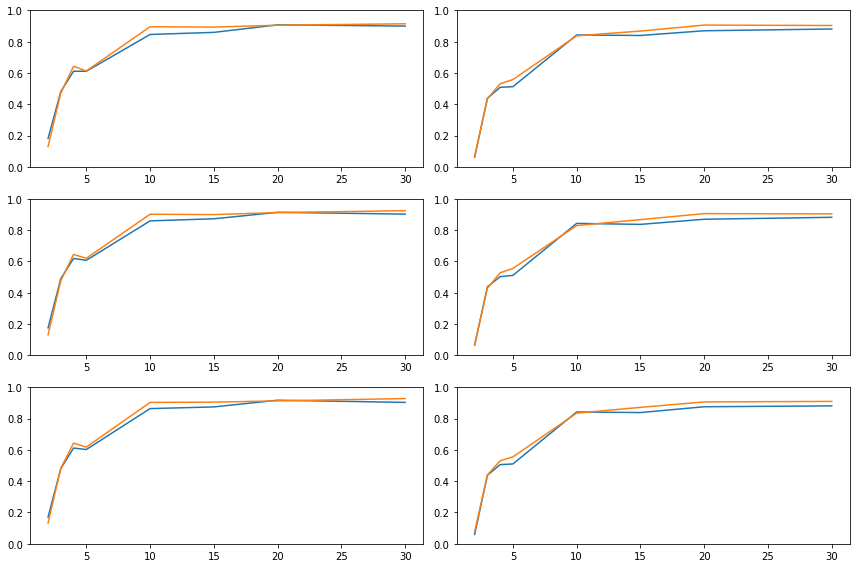

In [9]:
plt.figure(figsize=(12, 8))
for plot_idx in range(6):
    plt.subplot(3,2,plot_idx+1)
    plt.plot(num_neuron_list, notask_test_corr[:, plot_idx])
    plt.plot(num_neuron_list, task_test_corr[:, plot_idx])

    plt.ylim(0, 1)


plt.tight_layout()

In [10]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

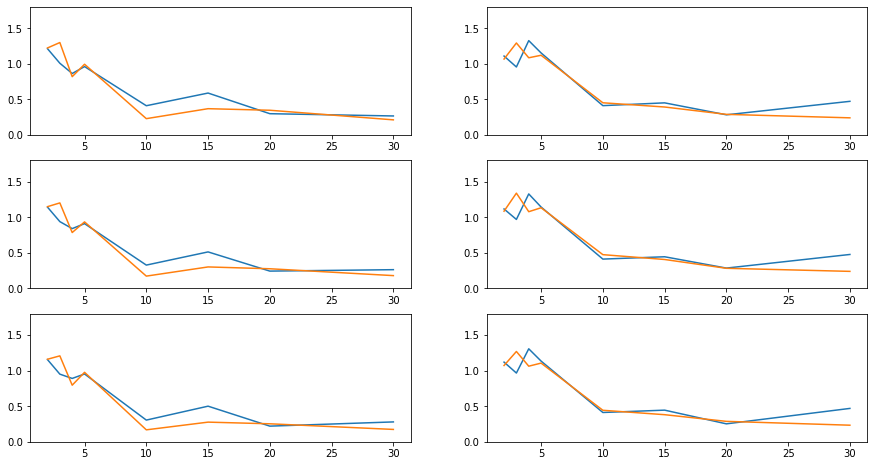

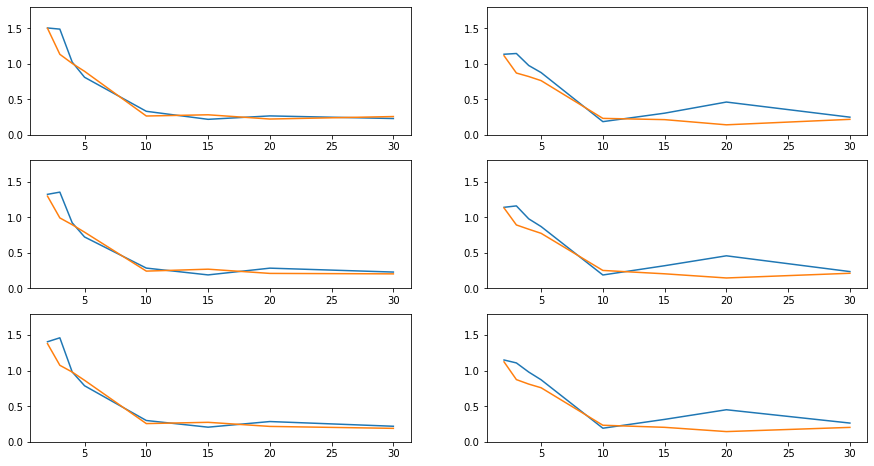

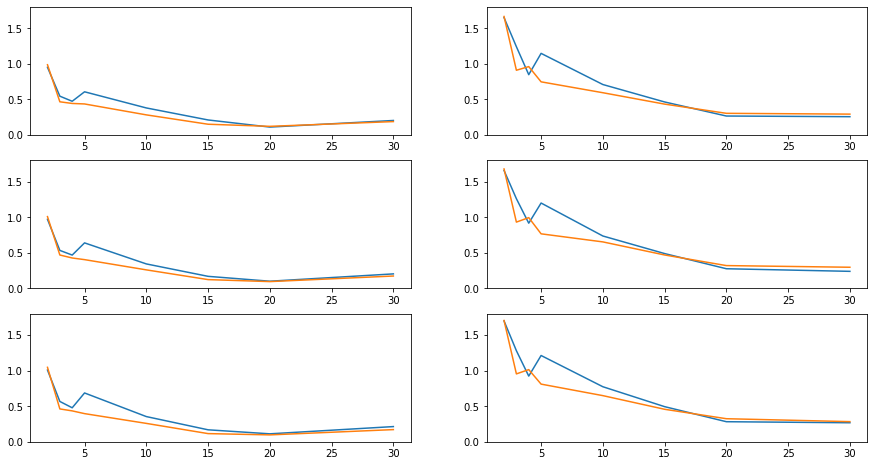

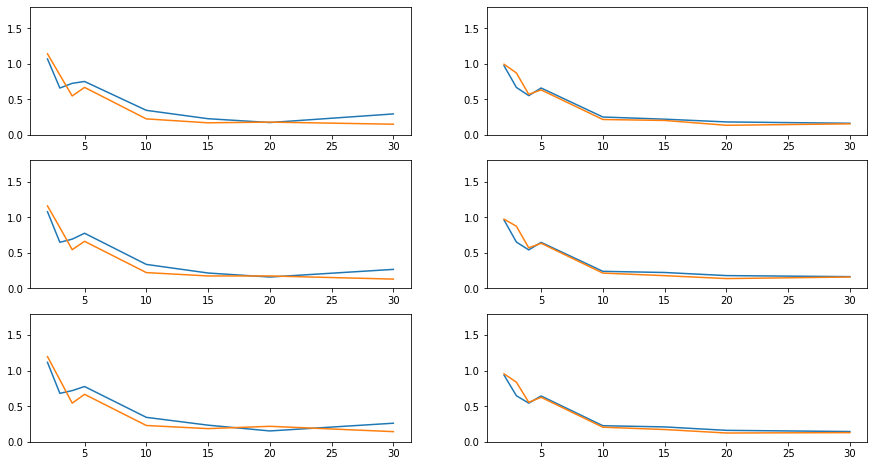

In [19]:
for layout_idx in range(1,5):
    label_mask = test_labels == layout_idx
    
    plt.figure(figsize=(15,8))
    for mrk_idx in range(6):
        plt.subplot(3,2,mrk_idx+1)

        notask_mse = list()
        task_mse = list()

        for num_neurons in num_neuron_list:
            # notask_error = np.sqrt(np.mean(np.square(num_neuron_results_dict[
            #     f'num_neuron_{num_neurons}']['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])))
            # task_error = np.sqrt(np.mean(np.square(num_neuron_results_dict[
            #     f'num_neuron_{num_neurons}']['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])))

            notask_error = np.mean(np.square(num_neuron_results_dict[
                f'num_neuron_{num_neurons}']['rnn']['notask']['test_pred'][label_mask,mrk_idx] - y_test_data[label_mask,mrk_idx]))
            task_error = np.mean(np.square(num_neuron_results_dict[
                f'num_neuron_{num_neurons}']['rnn']['task']['test_pred'][label_mask,mrk_idx] - y_test_data[label_mask,mrk_idx]))

            notask_mse.append(notask_error)
            task_mse.append(task_error)

        plt.plot(num_neuron_list, notask_mse)
        plt.plot(num_neuron_list, task_mse)
        plt.ylim(0, 1.8)



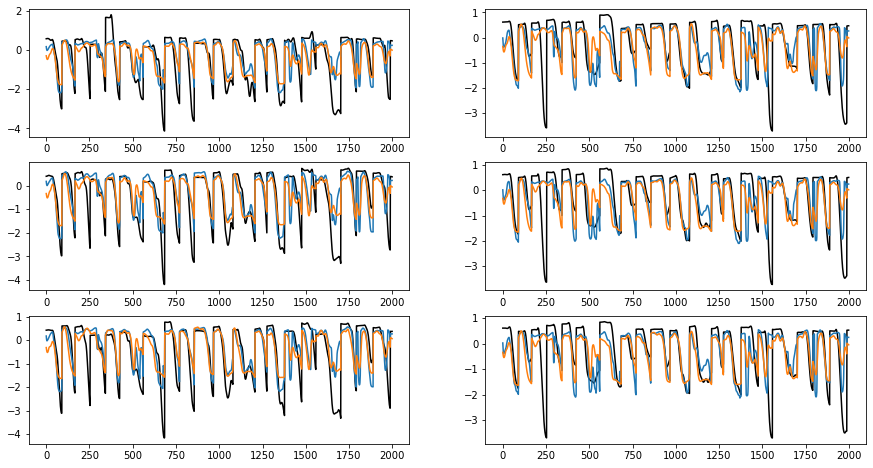

In [26]:
plt.figure(figsize=(15,8))
for mrk_idx in range(6):
    plt.subplot(3,2,mrk_idx+1)
    plt.plot(y_test_data[:2000,mrk_idx], color='k')
    plt.plot(num_neuron_results_dict['num_neuron_4']['rnn']['notask']['test_pred'][:2000,mrk_idx])
    plt.plot(num_neuron_results_dict['num_neuron_4']['rnn']['task']['test_pred'][:2000,mrk_idx])
    # plt.plot(num_neuron_results_dict['num_neuron_20']['wiener']['notask']['test_pred'][:2000,mrk_idx])
    # plt.plot(num_neuron_results_dict['num_neuron_20']['wiener']['task']['test_pred'][:2000,mrk_idx])


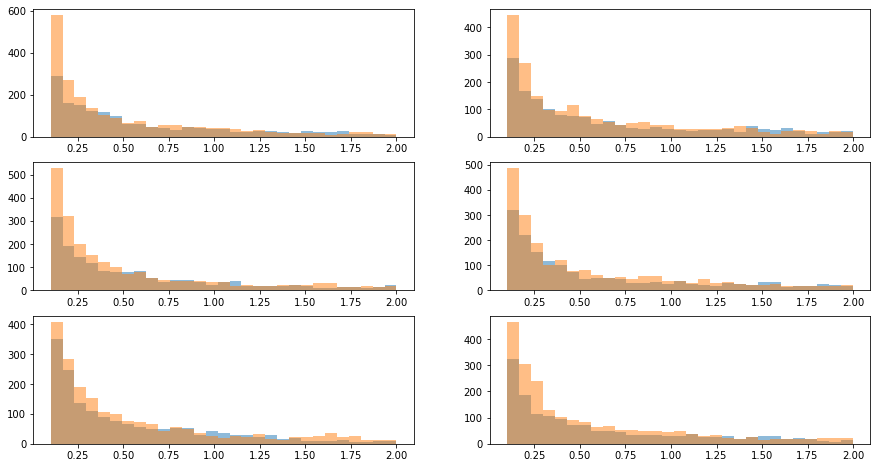

In [25]:
bins = np.linspace(0.1, 2, 30)
plt.figure(figsize=(15,8))
for mrk_idx in range(6):
    plt.subplot(3,2,mrk_idx+1)

    notask_mse = np.square(num_neuron_results_dict['num_neuron_4']['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])
    task_mse = np.square(num_neuron_results_dict['num_neuron_4']['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])

    plt.hist(notask_mse, bins=bins, alpha=0.5)
    plt.hist(task_mse, bins=bins, alpha=0.5)


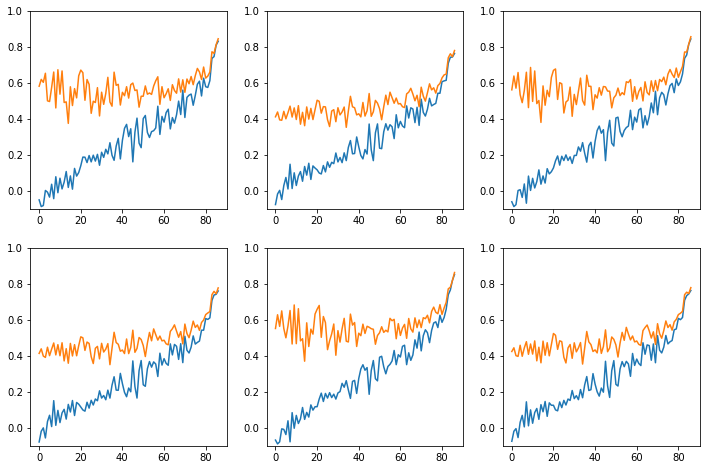

In [42]:
notask_corr_sort = wiener_test_dict['notask'][sort_indices, :]
task_corr_sort = wiener_test_dict['task'][sort_indices, :]

bins = np.linspace(-0.1,1,15)
plt.figure(figsize=(12, 8))
for plot_idx in range(6):
    plt.subplot(2,3,plot_idx+1)
    plt.plot(notask_corr_sort[:, plot_idx])
    plt.plot(task_corr_sort[:, plot_idx])

    plt.ylim(-0.1, 1)

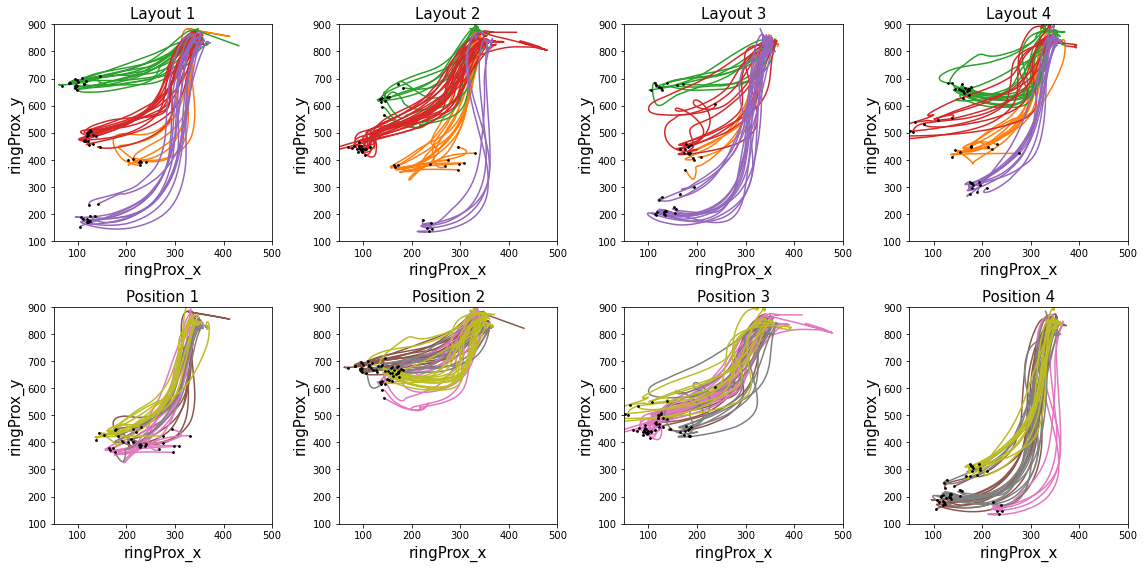

In [4]:
marker_name = 'ringProx'

plt.figure(figsize=(16,8))
fontsize=15

xmin, xmax = 50, 500
ymin, ymax =  100, 900

for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(2,4,layout_idx)
        mask = np.logical_and(wrist_df['position'] == position_idx, wrist_df['layout'] == layout_idx)
        filtered_df = wrist_df[mask]

        x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
        y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{position_idx}')

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Layout {layout_idx}', fontsize=fontsize)

        plt.subplot(2,4,position_idx + 4)
        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{layout_idx + 4}')
    
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Position {position_idx}', fontsize=fontsize)

plt.tight_layout()
        

In [15]:
def plot_trajectories(split_type='train_idx'):
    marker_name = 'ringProx'

    plt.figure(figsize=(16,8))
    fontsize=15

    xmin, xmax = 50, 500
    ymin, ymax =  100, 900

    trial_mask = np.in1d(wrist_df['trial'].values, cv_dict[data_dict['noise_fold']][split_type])
    trial_df = wrist_df[trial_mask]

    for position_idx in range(1,5):
        for layout_idx in range(1,5):
            plt.subplot(2,4,layout_idx)
            mask = np.logical_and(trial_df['position'] == position_idx, trial_df['layout'] == layout_idx)
            filtered_df = trial_df[mask]

            x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
            y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

            for plot_data in zip(x_data, y_data):
                plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
                plt.plot(plot_data[0], plot_data[1], color=f'C{position_idx}')

            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
            plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
            plt.title(f'Layout {layout_idx}', fontsize=fontsize)

            plt.subplot(2,4,position_idx + 4)
            for plot_data in zip(x_data, y_data):
                plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
                plt.plot(plot_data[0], plot_data[1], color=f'C{layout_idx + 4}')
        
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
            plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
            plt.title(f'Position {position_idx}', fontsize=fontsize)

    plt.tight_layout()
            

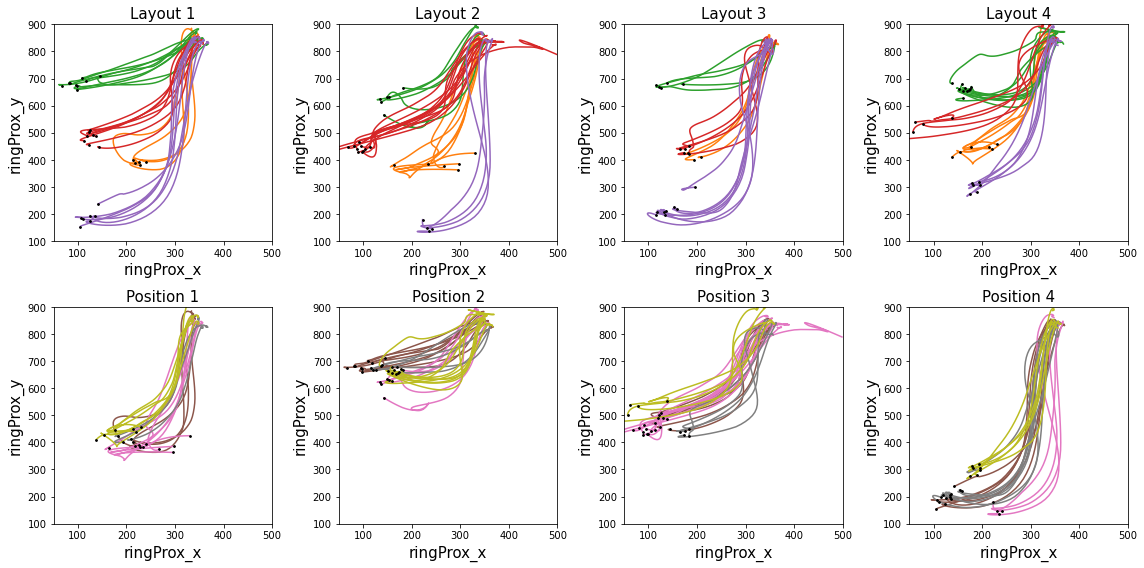

In [16]:
plot_trajectories('train_idx')

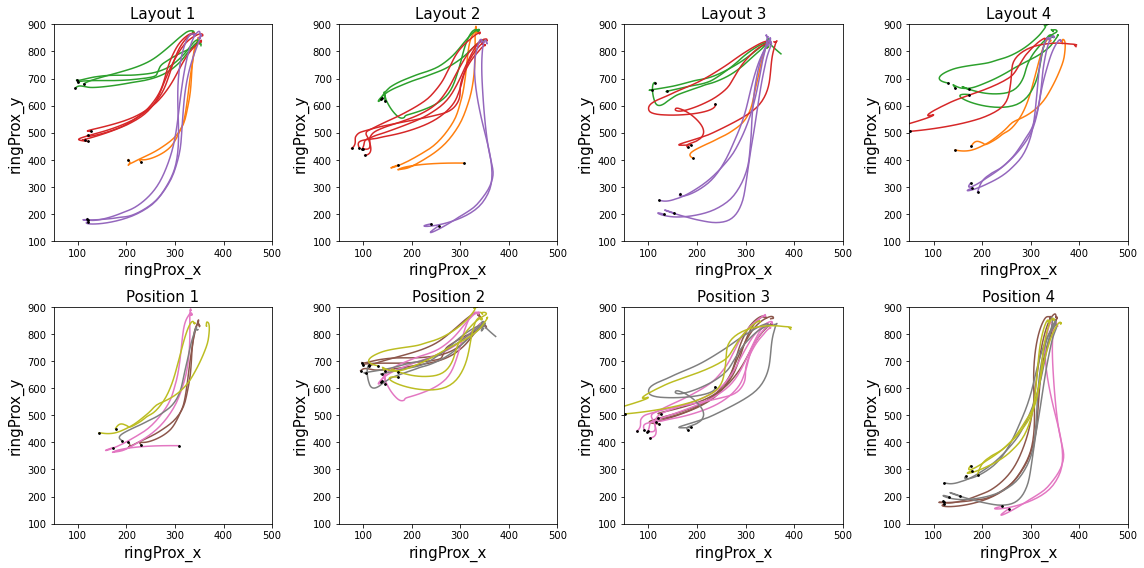

In [17]:
plot_trajectories('test_idx')

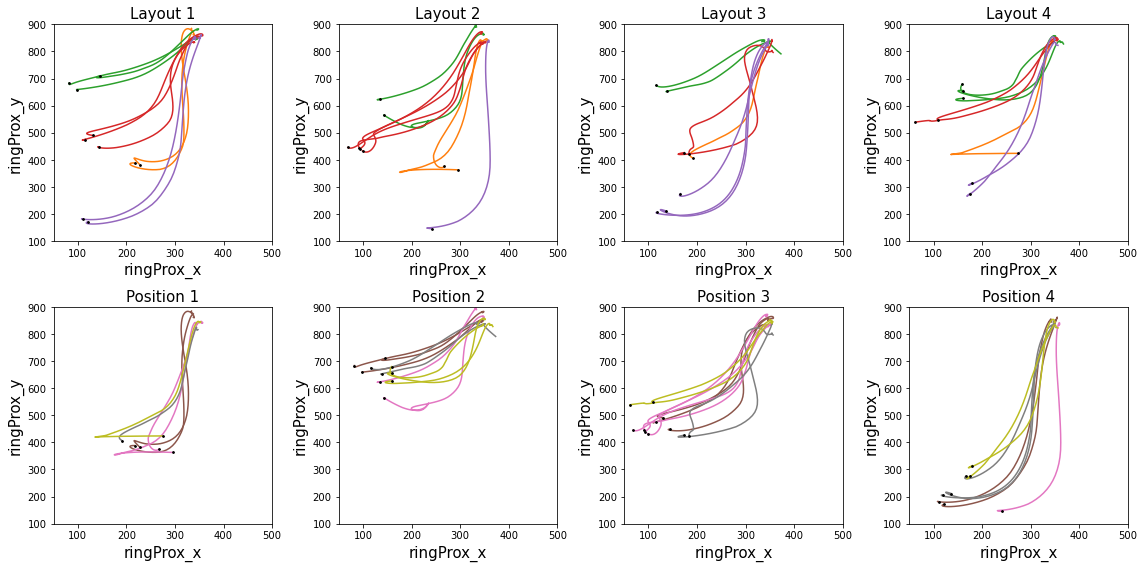

In [44]:
plot_trajectories('validation_idx')